**rajvi using steph's code**

In [6]:
from api.mapbox_api_walking import MapboxAPI
import requests
from urllib.request import urlopen
import json
from shapely.geometry import shape, Polygon
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import geopandas as gpd
import geodatasets
import ast
from shapely import wkt
import folium
from pyproj import Geod

In [7]:
branches = pd.read_csv('../data/clean/branches.csv')
populationDemographics = pd.read_csv('../data/clean/population_demographics.csv')

In [8]:
api = MapboxAPI()

In [9]:
branchRadii = gpd.read_file('../data/clean/branches.csv')

branchRadii = branchRadii.set_crs('EPSG:4326')
branchRadii[['LATITUDE', 'LONGITUDE']] = [ast.literal_eval(x)[:2] for x in branchRadii['LOCATION']]
branchRadii.loc[:, 'LATITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LATITUDE'])
branchRadii.loc[:, 'LONGITUDE'] = pd.to_numeric(branchRadii.loc[:, 'LONGITUDE'])
branchRadii.head()

for i in range(branchRadii.shape[0]):
    api_response =  api.get_data((branchRadii.loc[i,'LATITUDE'],branchRadii.loc[i,'LONGITUDE']), 20)
    branchRadii.loc[i,'geometry'] = shape(api_response)

branchRadii = branchRadii.set_index('BRANCH')
#api_response = api.get_data((branchRadii.loc['Altgeld','LATITUDE'],branchRadii.loc['Altgeld','LONGITUDE']), 20)
#branchRadii.loc['Altgeld','geometry'] = shape(api_response)

KeyError: 'features'

/tmp/ipykernel_2225750/3834977753.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
/tmp/ipykernel_2225750/3834977753.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
/opt/tljh/user/lib/python3.9/site-packages/geopandas/array.py:968: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 

ValueError: aspect must be finite and positive 

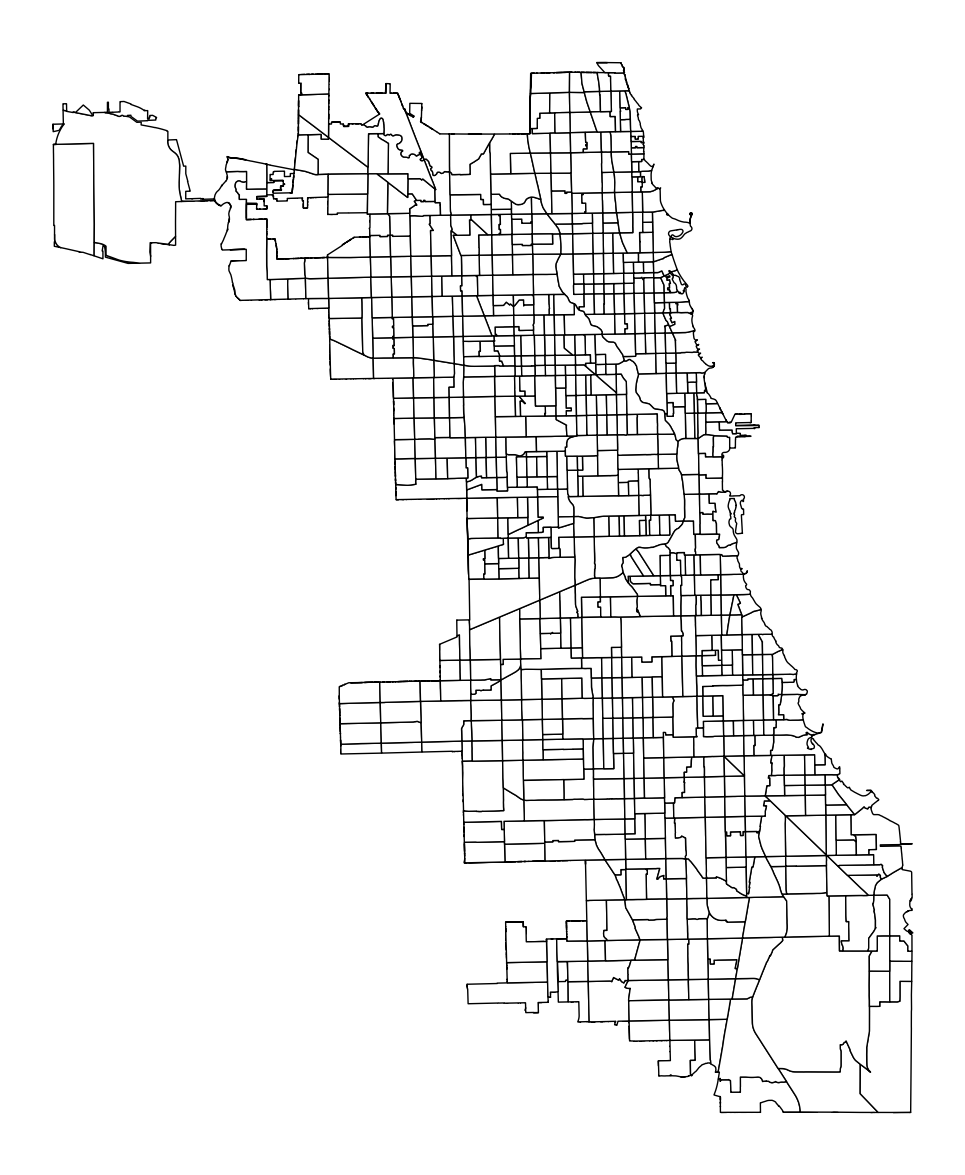

In [10]:
# this line makes a copy of the ageOnly data frame so we can manipulate without affecting our primary dataset
censusTracts = populationDemographics[['geoid','geometry','qualifying name', 'current land area (sq. m)', 'current water area (sq. m)', ]]
branchLocsOnly=branches[['BRANCH','LOCATION']]

# the following converts the data frame to a geo data frame and plots estimated percent of retired members of each community
censusTracts = gpd.GeoDataFrame(
    censusTracts.loc[:, [c for c in censusTracts.columns if c != "geometry"]],
    geometry=gpd.GeoSeries.from_wkt(censusTracts["geometry"]),
    crs="epsg:4326",
    )

branchLocsOnly.crs = 'EPSG:4326'
branchLocsOnly[['Latitude', 'Longitude']] = [ast.literal_eval(x)[:2] for x in branchLocsOnly['LOCATION']]
branchLocsOnly = branchLocsOnly.drop(columns='LOCATION')
#branchLocsOnly.head()

branchLocsOnly = gpd.GeoDataFrame(
    branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:4326")
    #branchLocsOnly, geometry=gpd.points_from_xy(branchLocsOnly.Longitude, branchLocsOnly.Latitude), crs="EPSG:32633")

fig, ax = plt.subplots(1, figsize=(15, 15))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black')
ax.axis('off')

branchRadii.plot(ax=base, alpha = .5)
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);


In [11]:
oneLib=pd.DataFrame
oneLib = pd.DataFrame(columns=['Census Tract','geometry'])
areaCalculations = pd.DataFrame(columns=['Census Tract','geometry'])
oneLib.reset_index(inplace = True)

# for loop to make dataframe of overlapping census tracts with the names of each census tract and polygon of area covered
# for loop also adds to new data frame which is collecting the name and geometry of the entire census tract that is partially or fully covered by
# the radius

geod=Geod(ellps='WGS84')
censusAreas = []


for index, row in censusTracts.iterrows():
    #print((branchRadii.intersection(row['geometry']))[0])
    oneBranch = gpd.GeoDataFrame({'geometry': [branchRadii.loc['Lincoln Belmont','geometry']]})
    if ((oneBranch.intersection(row['geometry']))[0]).is_empty:
        empty=[]
        empty.append("none")
    else:
        temp = pd.DataFrame({"Census Tract": row['geoid'],"geometry": [(oneBranch.intersection(row['geometry'])[0])]}, index=[0])
        oneLib=pd.concat([oneLib,temp])
        geomTemp = pd.DataFrame({"Census Tract": row['geoid'],"geometry": [(row['geometry'])]})
        areaCalculations = pd.concat([areaCalculations, geomTemp])


for index, row in areaCalculations.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area / -10**6
    censusAreas.append(poly_area)
    
areaCalculations['calculated area'] = censusAreas
areaCalculations.reset_index(inplace = True)

KeyError: 'Lincoln Belmont'

In [ ]:
areaCalculations

In [8]:

# convert oneLib to geodata frame and reasssign to crs used for area calculations (by default, its 4326 geometries)
oneLib = gpd.GeoDataFrame(oneLib, geometry="geometry")
oneLib = oneLib.set_crs(crs = 'epsg:4326')

oneLib.reset_index(inplace = True)

geod=Geod(ellps='WGS84')

overlappingAreas = []

for index, row in oneLib.iterrows():
    poly_area, poly_perimeter = geod.geometry_area_perimeter(row['geometry'])
    poly_area = poly_area / -10**6
    overlappingAreas.append(poly_area)

oneLib['Area Within Radius']= overlappingAreas
oneLib['census Area'] = areaCalculations['calculated area']

# using Geod method with WGS84 and espg:4326 gives us area in DEGREES not meters so the proportion is accurate but 
# the actual area values you have to convert to a different crs to be useful as distances



NameError: name 'oneLib' is not defined

In [9]:
print(oneLib.crs)

NameError: name 'oneLib' is not defined

In [ ]:
oneLib = oneLib.drop(columns='level_0')
oneLib['Percent Overlap'] = oneLib['Area Within Radius']/oneLib['census Area']

In [ ]:
oneLib = oneLib.drop(columns='index')
oneLib

In [ ]:
altgeldCensusOverlap20Walking1 = oneLib.copy(deep=True)
#altgeldCensusOverlap20Walking1.to_csv('../individual lib census/altgeldCensusOverlap20Walking1.csv')

In [ ]:
fig, ax = plt.subplots(1, figsize=(25, 25))
base = censusTracts.plot(ax=ax, color='white', edgecolor='black', linewidth=.5)
ax.axis('off')

altgeldCensusOverlap20Walking1.plot(ax=base, alpha = .5)
branchLocsOnly.plot(ax=base, marker='o', color='red', markersize=5);

